In [94]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Dense, Activation, Flatten


In [95]:
cwd = os.getcwd()
print(cwd)

/content/elephants-train


In [ ]:
%cd /content/elephants-train
!wget https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/elephants.zip
!wget https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/not-elephants.zip

/content/elephants-train
--2024-10-17 06:48:12--  https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/elephants.zip
Resolving www.ecst.csuchico.edu (www.ecst.csuchico.edu)... 132.241.1.13
Connecting to www.ecst.csuchico.edu (www.ecst.csuchico.edu)|132.241.1.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441647 (431K) [application/zip]
Saving to: ‘elephants.zip’

elephants.zip       100%[===================>] 431.30K  1.38MB/s    in 0.3s    

2024-10-17 06:48:13 (1.38 MB/s) - ‘elephants.zip’ saved [441647/441647]

--2024-10-17 06:48:13--  https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/not-elephants.zip
Resolving www.ecst.csuchico.edu (www.ecst.csuchico.edu)... 132.241.1.13
Connecting to www.ecst.csuchico.edu (www.ecst.csuchico.edu)|132.241.1.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10496805 (10M) [application/zip]
Saving to: ‘not-elephants.zip’

not-elephants.zip   100%[===================>]  10.01M  15.4MB/s    

In [ ]:
%cd /content/elephants-train
!unzip elephants.zip
!unzip not-elephants.zip


/content/elephants-train
Archive:  elephants.zip
   creating: elephants/
  inflating: elephants/elephant9-1.wav  
Archive:  not-elephants.zip
   creating: not-elephants/
  inflating: not-elephants/2-guinea-fowl-24469-1.wav  


In [96]:
elefile = os.path.join('/content', 'elephants-train', 'elephants', 'elephant9-1.wav')
notelefile = os.path.join('/content', 'elephants-train', 'not-elephants', '2-guinea-fowl-24469-1.wav')


In [97]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [98]:
wave = load_wav_16k_mono(elefile)
nwave =load_wav_16k_mono(notelefile)

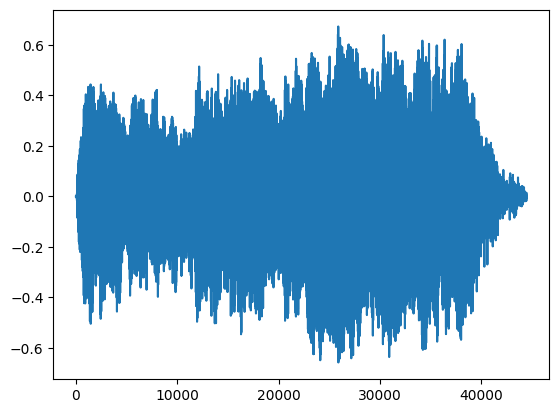

In [99]:
plt.plot(wave)
# plt.plot(nwave)
plt.show()

In [103]:
POS = os.path.join('/content', 'elephants-train', 'elephants')
NEG = os.path.join('/content', 'elephants-train', 'not-elephants')

In [104]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
data.as_numpy_iterator().next()

(b'elephants-train\\elephants\\elephant (12).wav', 1.0)

In [107]:
lengths = []
for file in os.listdir(os.path.join('/content', 'elephants-train', 'elephants')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content', 'elephants-train', 'elephants', file))
    lengths.append(len(tensor_wave))

In [108]:
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=44475>

In [109]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=920, frame_step=43)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [110]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [111]:
spectrogram, label = preprocess(filepath, label)


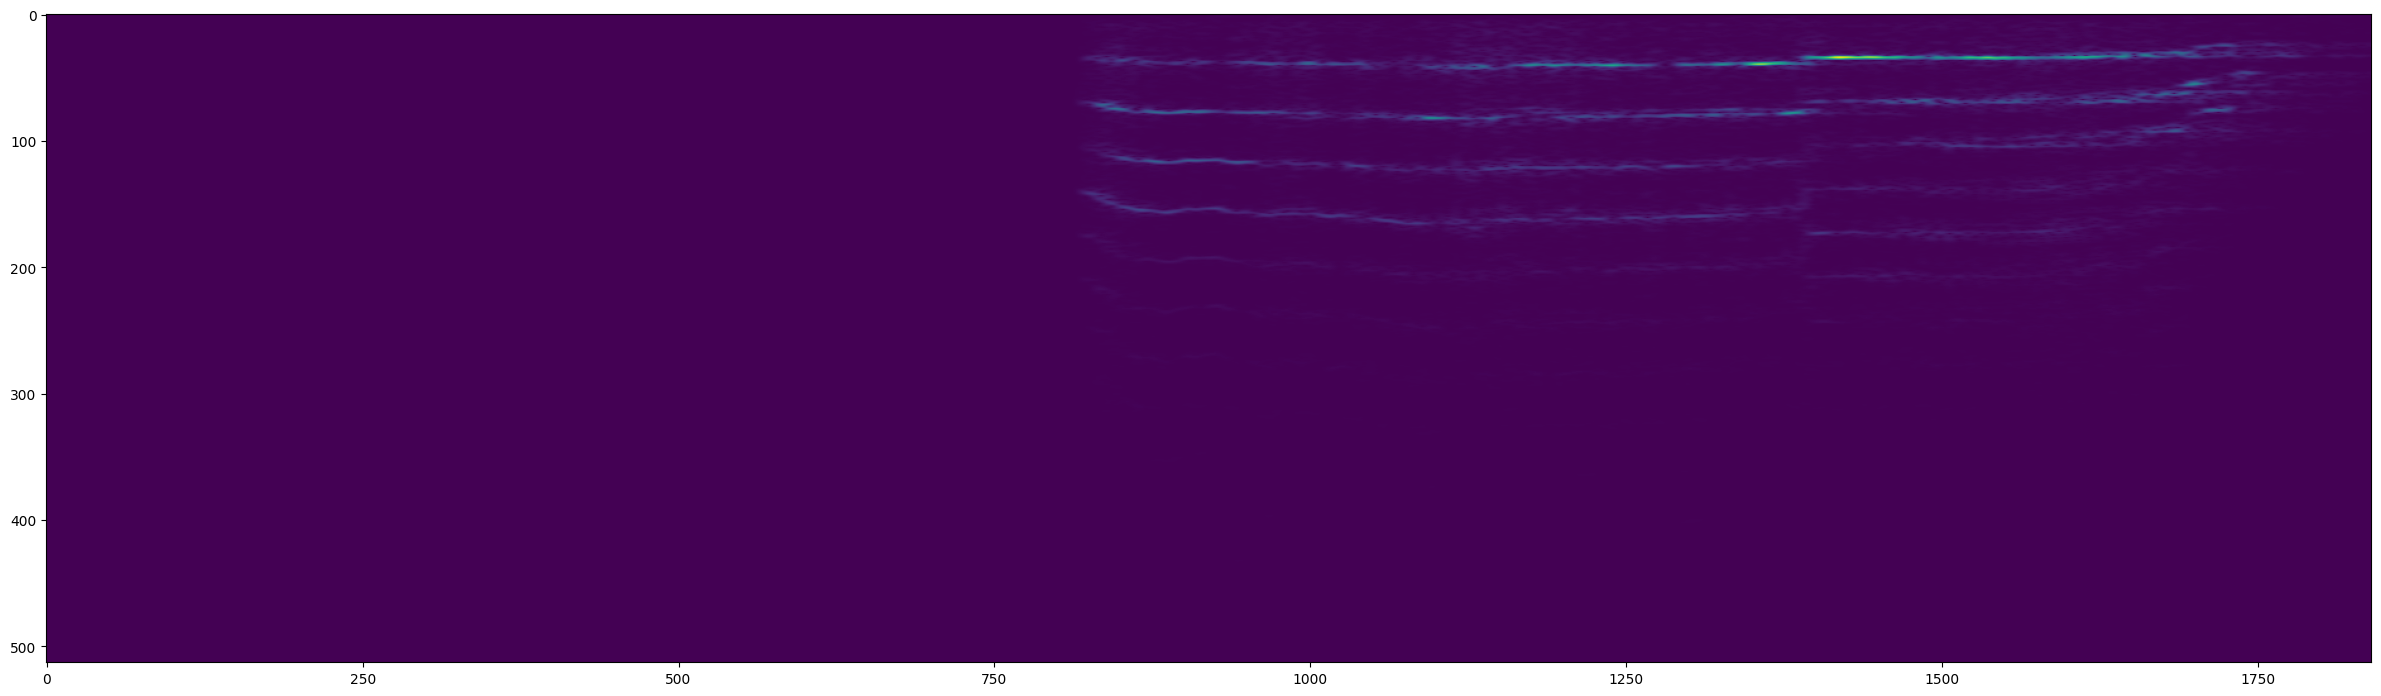

In [112]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [114]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=800)
data = data.batch(3)
data = data.prefetch(8)
data

TypeError: in user code:

    File "<ipython-input-82-5475eb1a640b>", line 2, in preprocess  *
        wav = load_wav_16k_mono(file_path)
    File "<ipython-input-71-ac7ad32adaf9>", line 3, in load_wav_16k_mono  *
        file_contents = tf.io.read_file(filename)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [115]:
spectrogram

<tf.Tensor: shape=(1840, 513, 1), dtype=float32, numpy=
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[5.4739375e-02],
        [4.1702604e-01],
        [6.5375388e-01],
        ...,
        [1.2815216e-06],
        [1.2395760e-06],
        [1.2330711e-06]],

       [[3.9331295e-02],
        [4.3046600e-01],
        [7.0002377e-01],
        ...,
        [1.2425281e-06],
        [1.0655111e-06],
        [1.4677644e-06]],

       [[1.0379992e-02],
        [4.5324540e-01],
        [7.5301629e-01],
        ...,
        [1.3072320

In [ ]:
len(data)*.7

59.49999999999999

In [ ]:
train = data.take(59)
test = data.skip(59).take(26)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

model = Sequential()
model.add(Conv2D(3, (3,3), activation='relu', input_shape=(1840,513,1)))
model.add(Conv2D(3, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(27, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model = Sequential()
model.add(Conv2D(3, (3,3), activation='relu', input_shape=(1840,513,1)))
model.add(Conv2D(3, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(27, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1838, 511, 3)      30        
                                                                 
 conv2d_1 (Conv2D)           (None, 1836, 509, 3)      84        
                                                                 
 flatten (Flatten)           (None, 2803572)           0         
                                                                 
 dense (Dense)               (None, 27)                75696471  
                                                                 
 dense_1 (Dense)             (None, 1)                 28        
                                                                 
Total params: 75,696,613
Trainable params: 75,696,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train,epochs=4, validation_data=test)

Epoch 1/4
59/59 [==============================] - 31s 410ms/step - loss: 2.9421 - recall: 0.6875 - precision: 0.6286 - val_loss: 0.4229 - val_recall: 0.5455 - val_precision: 1.0000
Epoch 2/4
59/59 [==============================] - 20s 345ms/step - loss: 1.0650 - recall: 0.9333 - precision: 0.8750 - val_loss: 0.3510 - val_recall: 0.9231 - val_precision: 1.0000
Epoch 3/4
59/59 [==============================] - 20s 348ms/step - loss: 0.0983 - recall: 1.0000 - precision: 0.9737 - val_loss: 0.0745 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
59/59 [==============================] - 20s 345ms/step - loss: 0.2587 - recall: 0.9697 - precision: 1.0000 - val_loss: 0.0593 - val_recall: 1.0000 - val_precision: 1.0000


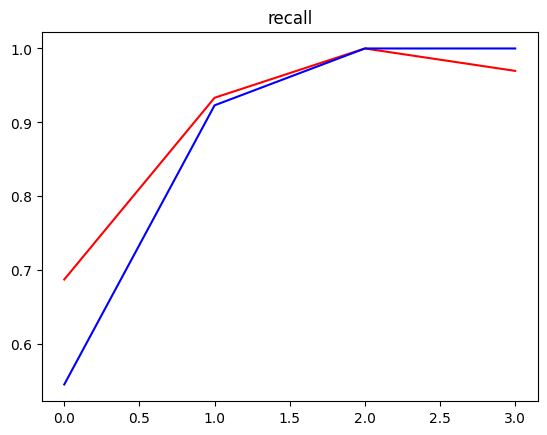

In [ ]:
plt.title('recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

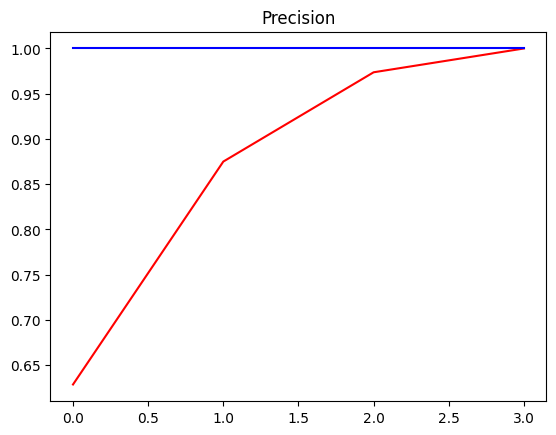

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

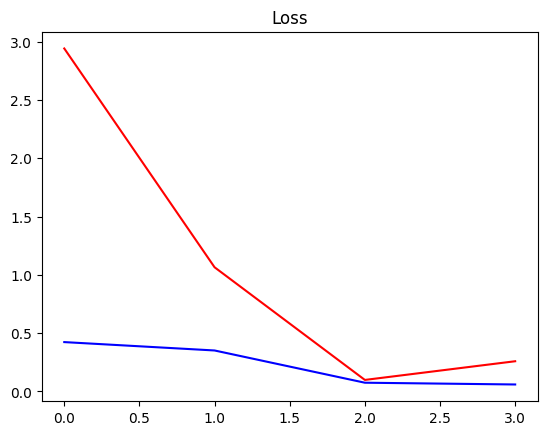

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
x_test,y_test = test.as_numpy_iterator().next()
y_test


array([0., 0., 0.], dtype=float32)

In [ ]:
y_test.shape

(3,)

In [ ]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 47ms/step


In [ ]:
# convert logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]#forloop

In [ ]:
yhat

[0, 0, 0]

In [ ]:
y_test.astype(int)

array([0, 0, 0])

In [ ]:
#a. load up mp3s

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3=os.path.join('elephants-train', 'test.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
# slice audio into the same size slices model was trained on
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=80000, sequence_stride=80000, batch_size=1)


In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()


In [ ]:
samples.shape

(1, 80000)

In [ ]:
# b. Build Function to Convert Clips into Windowed Spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([80000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=920, frame_step=43)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram


In [ ]:
# convert longer clips into windows and make predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=80000, sequence_stride=80000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)


In [ ]:
yhat = model.predict(audio_slices)


1/1 [==============================] - 1s 1s/step


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]#forloop

In [ ]:
yhat

[0, 0, 0, 1, 1, 0, 0]

In [ ]:
len(yhat)

7

In [ ]:
model.save('newdetection')

INFO:tensorflow:Assets written to: newdetection\assets


INFO:tensorflow:Assets written to: newdetection\assets
